In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.pyplot import *
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import os
from PIL import Image
import torchvision.transforms.functional as TF
import time
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
cuda = torch.cuda.is_available()
cuda

True

In [3]:
!pip install torchsummary
from torchsummary import summary

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
from google.colab import files
kaggle=files.upload()

Saving kaggle.json to kaggle.json


In [6]:
!pip install -q kaggle

In [7]:
!mkdir -p ~/.kaggle

In [8]:
!cp kaggle.json ~/.kaggle/

In [9]:
! kaggle datasets download -d yash612/covidnet-mini-and-gan-enerated-chest-xray

100% 1.50G/1.51G [00:38<00:00, 43.2MB/s]
100% 1.51G/1.51G [00:38<00:00, 42.3MB/s]


In [10]:
! unzip covidnet-mini-and-gan-enerated-chest-xray.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray204.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray205.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray206.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray207.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray208.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray209.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray21.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray210.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray211.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray212.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray213.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray214.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORM

In [11]:
trans_apply=transforms.Compose([transforms.Resize((384,384)),transforms.ToTensor()])

torch.Size([3, 384, 384])
3


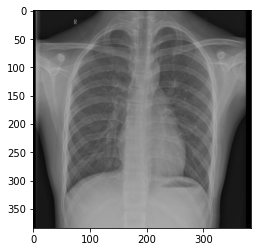

In [14]:
plt.imshow(np.transpose(test_dataset[100][0],axes=(1,2,0)))
print(train_dataset[1600][0].shape)
print(len(train_dataset.classes))
n_classes=len(train_dataset.classes)

In [13]:
train_dataset=datasets.ImageFolder('data/chest_xray/chest_xray/train',transform=trans_apply)
val_dataset=datasets.ImageFolder('data/chest_xray/chest_xray/val',transform=trans_apply)
test_dataset=datasets.ImageFolder('data/chest_xray/chest_xray/test',transform=trans_apply)

In [15]:
print("train",train_dataset.__len__(), len(train_dataset.classes))
print("val",val_dataset.__len__(), len(val_dataset.classes))
print("test",test_dataset.__len__(), len(test_dataset.classes))

train 5882 3
val 27 3
test 635 3


In [16]:
num_workers = 12 if cuda else 0 
    
# Training data
train_loader_args = dict(shuffle=True, batch_size=10, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=800)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

# Validation data
val_loader_args = dict(shuffle=True, batch_size=10, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=500)
val_loader = data.DataLoader(val_dataset, **val_loader_args)

# Testing data
test_loader_args = dict(shuffle=False, num_workers=num_workers) if cuda\
                    else dict(shuffle=False,drop_last=True)
test_loader = data.DataLoader(test_dataset, **test_loader_args)


In [17]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            nn.Dropout(p = 0.1),
            nn.ReLU(inplace=True)
        )
class InvertedBottleneck(nn.Module):
    
    def __init__(self, in_channels, inter_channels):
        super(InvertedBottleneck, self).__init__()
        self.convbnrl1 = ConvBNReLU(in_channels, inter_channels, kernel_size = 1, stride = 1)
        self.convbnrl2 = ConvBNReLU(inter_channels, inter_channels, kernel_size = 3, stride = 1, groups = inter_channels)
        self.convbnrl3 = ConvBNReLU(inter_channels, inter_channels, kernel_size = 1, stride = 1)
        self.conv = nn.Conv2d(inter_channels, in_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn = nn.BatchNorm2d(in_channels, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True)

        
    def forward(self, x):
        out = self.convbnrl1(x)
        out = self.convbnrl2(out)
        out = self.convbnrl3(out)
        out = self.conv(out)
        out = self.bn(out)
        out += x
    
        return out

class Transit(nn.Module):
    
    def __init__(self, in_channels, out_channels, padding = 0):
        super(Transit, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True)
        self.rl = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.rl(out)
        return out

class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super(Block, self).__init__()
        self.IB1 = InvertedBottleneck(in_channels, 4 * in_channels)
        self.transit = Transit(in_channels, out_channels, padding = 1)
        self.IB2 = InvertedBottleneck(out_channels, 4 * out_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
    
    def forward(self, x):
        out = self.IB1(x)
        out = self.transit(out)
        out = self.IB2(out)
        out += self.conv(x)

        
        return out

In [18]:
class Network(nn.Module):
    def __init__(self, num_feats, hidden_sizes, num_classes, feat_dim=10):
        super(Network, self).__init__()
        
        self.hidden_sizes = [num_feats] + hidden_sizes + [num_classes]
        
        self.layers = []
        
        self.layers.append(nn.Conv2d(num_feats, self.hidden_sizes[1], kernel_size = 3, stride = 2, bias = False))
        self.layers.append(nn.BatchNorm2d(self.hidden_sizes[1], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.layers.append(nn.ReLU(inplace = True))
        for idx in range(1, len(self.hidden_sizes) - 2):
            in_channels = self.hidden_sizes[idx]
            out_channels = self.hidden_sizes[idx + 1]
            
            self.layers.append(Block(in_channels, out_channels))
            
    
        self.layers = nn.Sequential(*self.layers)
        self.linear_label = nn.Linear(self.hidden_sizes[-2], self.hidden_sizes[-1])
        
        # For creating the embedding to be passed into the Center Loss criterion
        #self.linear_closs = nn.Linear(self.hidden_sizes[-2], feat_dim, bias=False)
        #self.relu_closs = nn.ReLU(inplace=True)
    
    def forward(self, x, evalMode=False):
        output = x
        output = self.layers(output)
            
        output = F.avg_pool2d(output, [output.size(2), output.size(3)], stride=1)
        output = output.reshape(output.shape[0], output.shape[1])
        
        label_output = self.linear_label(output)
        label_output = label_output/torch.norm(self.linear_label.weight, dim=1)
        
        # Create the feature embedding for the Center Loss
        #closs_output = self.linear_closs(output)
        #closs_output = self.relu_closs(closs_output)

        return label_output

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)


In [19]:

numEpochs = 10
num_feats = 3
closs_weight = 1
feat_dim = 10

learningRate = 1e-2
weightDecay = 5e-5

hidden_sizes = [3, 6, 12, 25]
num_classes = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [20]:
from torch import optim

network = Network(num_feats, hidden_sizes, num_classes)
network.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr = 0.0001)
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")


In [21]:
def train(model, data_loader, test_loader, task='Classification'):
    model.train()

    for epoch in range(numEpochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(data_loader):
            feats, labels = feats.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(feats)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()

            if batch_num % 50 == 49:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
                avg_loss = 0.0    
            
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        
        if task == 'Classification':
            val_loss, val_acc = test_classify(model, test_loader)
            train_loss, train_acc = test_classify(model, data_loader)
            print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}\tVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.
                  format(train_loss, train_acc, val_loss, val_acc))
        else:
         
            pass


def test_classify(model, test_loader):
    model.eval()
    test_loss = []
    accuracy = 0
    total = 0

    for batch_num, (feats, labels) in enumerate(test_loader):
        feats, labels = feats.to(device), labels.to(device)
        outputs = model(feats)
        
        _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
        pred_labels = pred_labels.view(-1)
        
        loss = criterion(outputs, labels.long())
        
        accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)
        test_loss.extend([loss.item()]*feats.size()[0])
        del feats
        del labels

    model.train()
    return np.mean(test_loss), accuracy/total

In [22]:
network.train()
network.to(device)
train(network, train_loader, val_loader)

Epoch: 1	Batch: 50	Avg-Loss: 1.3349
Epoch: 1	Batch: 100	Avg-Loss: 1.1127
Epoch: 1	Batch: 150	Avg-Loss: 0.9448
Epoch: 1	Batch: 200	Avg-Loss: 0.7854
Epoch: 1	Batch: 250	Avg-Loss: 0.7251
Epoch: 1	Batch: 300	Avg-Loss: 0.6593
Epoch: 1	Batch: 350	Avg-Loss: 0.6076
Epoch: 1	Batch: 400	Avg-Loss: 0.6162
Epoch: 1	Batch: 450	Avg-Loss: 0.5754
Epoch: 1	Batch: 500	Avg-Loss: 0.5709
Epoch: 1	Batch: 550	Avg-Loss: 0.5682
Train Loss: 0.9799	Train Accuracy: 0.6933	Val Loss: 1.8629	Val Accuracy: 0.3333
Epoch: 2	Batch: 50	Avg-Loss: 0.5254
Epoch: 2	Batch: 100	Avg-Loss: 0.5520
Epoch: 2	Batch: 150	Avg-Loss: 0.5202
Epoch: 2	Batch: 200	Avg-Loss: 0.5177
Epoch: 2	Batch: 250	Avg-Loss: 0.4804
Epoch: 2	Batch: 300	Avg-Loss: 0.5287
Epoch: 2	Batch: 350	Avg-Loss: 0.4810
Epoch: 2	Batch: 400	Avg-Loss: 0.5243
Epoch: 2	Batch: 450	Avg-Loss: 0.4723
Epoch: 2	Batch: 500	Avg-Loss: 0.5209
Epoch: 2	Batch: 550	Avg-Loss: 0.5089
Train Loss: 0.8495	Train Accuracy: 0.6948	Val Loss: 1.5234	Val Accuracy: 0.5185
Epoch: 3	Batch: 50	Avg-Loss: